<a href="https://colab.research.google.com/github/bcdanl/320-code/blob/main/danl_320_script_2025_0226.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate  # for table summary
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm  # for lowess smoothing

from pyspark.sql import SparkSession
from pyspark.sql.functions import rand, col, pow, mean, when, log
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
def regression_table(model, assembler):
    """
    Creates a formatted regression table from a fitted LinearRegression model and its VectorAssembler,
    and inserts a dashed horizontal line after the Intercept row. The table includes separate columns
    for the 95% confidence interval lower and upper bounds for each coefficient (computed at the 5% significance level)
    and an "Observations" row (using model.summary.numInstances) above the R² row.
    The RMSE row is placed as the last row.

    The columns are ordered as:
        Metric | Value | Significance | Std. Error | p-value | 95% CI Lower | 95% CI Upper

    For the "Value", "Std. Error", "95% CI Lower", and "95% CI Upper" columns, commas are inserted every three digits,
    with 3 decimal places (except for Observations which is formatted as an integer with commas).

    Parameters:
        model: A fitted LinearRegression model (with a .summary attribute).
        assembler: The VectorAssembler used to assemble the features for the model.

    Returns:
        A formatted string containing the regression table.
    """
    # Extract coefficients and standard errors as NumPy arrays
    coeffs = model.coefficients.toArray()
    std_errors_all = np.array(model.summary.coefficientStandardErrors)

    # Check if the intercept's standard error is included (one extra element)
    if len(std_errors_all) == len(coeffs) + 1:
        intercept_se = std_errors_all[0]
        std_errors = std_errors_all[1:]
    else:
        intercept_se = None
        std_errors = std_errors_all

    # Compute t-statistics for feature coefficients (t = beta / SE(beta))
    # t_stats = coeffs / std_errors
    t_stats = model.summary.tValues

    # Degrees of freedom: number of instances minus number of predictors minus 1 (for intercept)
    df = model.summary.numInstances - len(coeffs) - 1

    # Compute the t-critical value for a 95% confidence interval (two-tailed, 5% significance)
    t_critical = stats.t.ppf(0.975, df)

    # Compute two-tailed p-values for each feature coefficient
    # p_values = [2 * (1 - stats.t.cdf(np.abs(t), df)) for t in t_stats]
    p_values = model.summary.pValues

    # Function to assign significance stars based on p-value
    def significance_stars(p):
        if p < 0.01:
            return "***"
        elif p < 0.05:
            return "**"
        elif p < 0.1:
            return "*"
        else:
            return ""

    # Build the table rows.
    # Order: Metric, Value, Significance, Std. Error, p-value, 95% CI Lower, 95% CI Upper.
    table = []
    for feature, beta, se, p in zip(assembler.getInputCols(), coeffs, std_errors, p_values):
        ci_lower = beta - t_critical * se
        ci_upper = beta + t_critical * se
        table.append([
            "Beta: " + feature,       # Metric name
            beta,                     # Beta estimate (Value)
            significance_stars(p),    # Significance stars
            se,                       # Standard error
            p,                        # p-value
            ci_lower,                 # 95% CI lower bound
            ci_upper                  # 95% CI upper bound
        ])

    # Compute and add the intercept row with its SE, p-value, significance, and CI (if available)
    if intercept_se is not None:
        intercept_t = model.intercept / intercept_se
        intercept_p = 2 * (1 - stats.t.cdf(np.abs(intercept_t), df))
        intercept_sig = significance_stars(intercept_p)
        ci_intercept_lower = model.intercept - t_critical * intercept_se
        ci_intercept_upper = model.intercept + t_critical * intercept_se
    else:
        intercept_se = ""
        intercept_p = ""
        intercept_sig = ""
        ci_intercept_lower = ""
        ci_intercept_upper = ""

    table.append([
        "Intercept",
        model.intercept,
        intercept_sig,
        intercept_se,
        intercept_p,
        ci_intercept_lower,
        ci_intercept_upper
    ])

    # Append overall model metrics:
    # Insert an Observations row using model.summary.numInstances,
    # then an R² row, and finally the RMSE row as the last row.
    table.append(["Observations", model.summary.numInstances, "", "", "", "", ""])
    table.append(["R²", model.summary.r2, "", "", "", "", ""])
    table.append(["RMSE", model.summary.rootMeanSquaredError, "", "", "", "", ""])

    # Format the table.
    # For the "Value" (index 1), "Std. Error" (index 3), "95% CI Lower" (index 5), and "95% CI Upper" (index 6) columns,
    # format with commas and 3 decimal places, except for Observations which should be an integer with commas.
    # For the p-value (index 4), format to 3 decimal places.
    formatted_table = []
    for row in table:
        formatted_row = []
        for i, item in enumerate(row):
            if row[0] == "Observations" and i == 1 and isinstance(item, (int, float, np.floating)) and item != "":
                # Format Observations as integer with commas, no decimals.
                formatted_row.append(f"{int(item):,}")
            elif isinstance(item, (int, float, np.floating)) and item != "":
                if i in [1, 3, 5, 6]:
                    formatted_row.append(f"{item:,.3f}")
                elif i == 4:
                    formatted_row.append(f"{item:.3f}")
                else:
                    formatted_row.append(f"{item:.3f}")
            else:
                formatted_row.append(item)
        formatted_table.append(formatted_row)

    # Generate the table string using tabulate.
    table_str = tabulate(
        formatted_table,
        headers=["Metric", "Value", "Sig.", "Std. Error", "p-value", "95% CI Lower", "95% CI Upper"],
        tablefmt="pretty",
        colalign=("left", "right", "center", "right", "right", "right", "right")
    )

    # Insert a dashed line after the Intercept row for clarity.
    lines = table_str.split("\n")
    dash_line = '-' * len(lines[0])
    for i, line in enumerate(lines):
        if "Intercept" in line and not line.strip().startswith('+'):
            lines.insert(i+1, dash_line)
            break

    return "\n".join(lines)

# Example usage:
# print(regression_table(MODEL, ASSEMBLER))

def add_dummy_variables(var_name, reference_level, category_order=None):
    """
    Creates dummy variables for the specified column in the global DataFrames dtrain and dtest.
    Allows manual setting of category order.

    Parameters:
        var_name (str): The name of the categorical column (e.g., "borough_name").
        reference_level (int): Index of the category to be used as the reference (dummy omitted).
        category_order (list, optional): List of categories in the desired order. If None, categories are sorted.

    Returns:
        dummy_cols (list): List of dummy column names excluding the reference category.
        ref_category (str): The category chosen as the reference.
    """
    global dtrain, dtest

    # Get distinct categories from the training set.
    categories = dtrain.select(var_name).distinct().rdd.flatMap(lambda x: x).collect()

    # Convert booleans to strings if present.
    categories = [str(c) if isinstance(c, bool) else c for c in categories]

    # Use manual category order if provided; otherwise, sort categories.
    if category_order:
        # Ensure all categories are present in the user-defined order
        missing = set(categories) - set(category_order)
        if missing:
            raise ValueError(f"These categories are missing from your custom order: {missing}")
        categories = category_order
    else:
        categories = sorted(categories)

    # Validate reference_level
    if reference_level < 0 or reference_level >= len(categories):
        raise ValueError(f"reference_level must be between 0 and {len(categories) - 1}")

    # Define the reference category
    ref_category = categories[reference_level]
    print("Reference category (dummy omitted):", ref_category)

    # Create dummy variables for all categories
    for cat in categories:
        dummy_col_name = var_name + "_" + str(cat).replace(" ", "_")
        dtrain = dtrain.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))
        dtest = dtest.withColumn(dummy_col_name, when(col(var_name) == cat, 1).otherwise(0))

    # List of dummy columns, excluding the reference category
    dummy_cols = [var_name + "_" + str(cat).replace(" ", "_") for cat in categories if cat != ref_category]

    return dummy_cols, ref_category


# Example usage without category_order:
# dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)

# Example usage with category_order:
# custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
# dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

In [4]:
# 1. Read CSV data from URL
df_pd = pd.read_csv('https://bcdanl.github.io/data/bikeshare_cleaned.csv')
df = spark.createDataFrame(df_pd)
df.show()

+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+
|cnt|year|month|date| hr|   wkday|holiday|seasons|        weather_cond|              temp|              hum|         windspeed|
+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+
| 16|2011|    1|   1|  0|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.947345243330896|  -1.5538438052971|
| 40|2011|    1|   1|  1|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|
| 32|2011|    1|   1|  2|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|
| 13|2011|    1|   1|  3|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217591|  -1.5538438052971|
|  1|2011|    1|   1|  4|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217

In [5]:
dtrain, dtest = df.randomSplit([0.6, 0.4], seed = 1234)


In [6]:
dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)
dummy_cols_month, ref_category_month = add_dummy_variables('month', 0)
dummy_cols_hr, ref_category_hr = add_dummy_variables('hr', 0)

# Example usage with category_order:
custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

dummy_cols_holiday, ref_category_holiday = add_dummy_variables('holiday', 0)

# Example usage with category_order:
custom_order_seasons = ['spring', 'summer', 'fall', 'winter']
dummy_cols_seasons, ref_category_seasons = add_dummy_variables('seasons', 0, custom_order_seasons)

dummy_cols_weather_cond, ref_category_weather_cond = add_dummy_variables('weather_cond', 0)


Reference category (dummy omitted): 2011
Reference category (dummy omitted): 1
Reference category (dummy omitted): 0
Reference category (dummy omitted): sunday
Reference category (dummy omitted): 0
Reference category (dummy omitted): spring
Reference category (dummy omitted): Clear or Few Cloudy


In [7]:
conti_cols = ["temp", "hum", "windspeed"]
assembler_predictors = (
    conti_cols +
    dummy_cols_year + dummy_cols_month +
    dummy_cols_hr + dummy_cols_wkday +
    dummy_cols_holiday + dummy_cols_seasons + dummy_cols_weather_cond
)

assembler_dum = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)
dtrain_dum = assembler_dum.transform(dtrain)
dtest_dum  = assembler_dum.transform(dtest)

model_dum = (
    LinearRegression(featuresCol="predictors",
                     labelCol="cnt")
    .fit(dtrain_dum)
)
dtest_dum = model_dum.transform(dtest_dum) # Q4. adding prediction column to test data

# For model_dum and assembler:
print( regression_table(model_dum, assembler_dum) )

+---------------------------------------------+---------+------+------------+---------+--------------+--------------+
| Metric                                      |   Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+---------------------------------------------+---------+------+------------+---------+--------------+--------------+
| Beta: temp                                  |  45.307 | ***  |      1.395 |   0.000 |       42.573 |       48.042 |
| Beta: hum                                   | -17.193 | ***  |      1.095 |   0.000 |      -19.339 |      -15.046 |
| Beta: windspeed                             |  -4.617 | ***  |      2.029 |   0.000 |       -8.595 |       -0.639 |
| Beta: year_2012                             |  85.361 | ***  |      5.129 |   0.000 |       75.308 |       95.414 |
| Beta: month_2                               |   8.508 |  *   |      5.765 |   0.097 |       -2.792 |       19.809 |
| Beta: month_3                               |  18.322 

# Q7
- Draw a coefficient plot for temp, hum and windspeed variables.


In [8]:
terms = assembler_dum.getInputCols()
coefs = model_dum.coefficients.toArray()[:len(terms)]
stdErrs = model_dum.summary.coefficientStandardErrors[:len(terms)]

df_summary = pd.DataFrame({
    "term": terms,
    "estimate": coefs,
    "std_error": stdErrs
})
df_summary

,term,estimate,std_error
0,temp,45.307008,2.361551
1,hum,-17.192597,1.395017
2,windspeed,-4.616665,1.094844
3,year_2012,85.360630,2.029418
4,month_2,8.508350,5.128514
5,month_3,18.322032,5.764897
6,month_4,10.783798,8.556570
7,month_5,25.990290,9.176854
8,month_6,4.946636,9.401748
9,month_7,-10.676807,10.543018


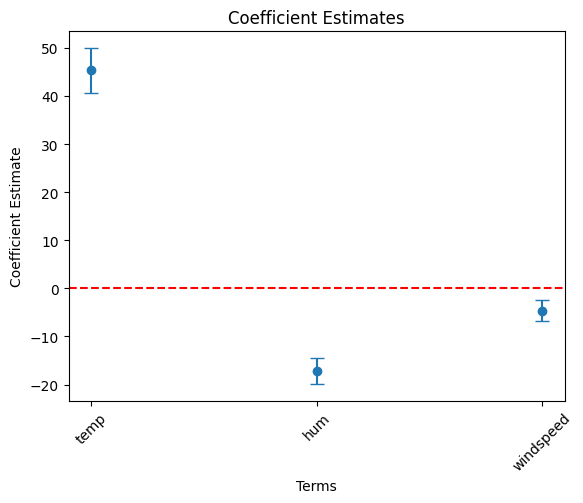

In [10]:
# Filter df_summary if needed
cond = df_summary['term'].isin(['temp', 'hum', 'windspeed'])

df_summary_1 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_1["term"], df_summary_1["estimate"],
             yerr = 1.96 * df_summary_1["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

- Draw a coefficient plot for month variables.

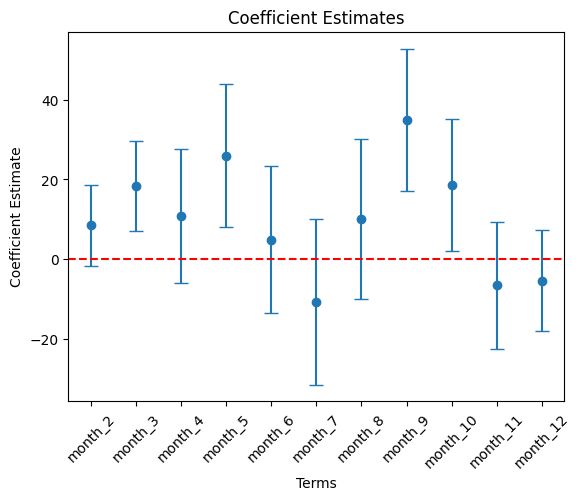

In [11]:
# Filter df_summary if needed
cond = df_summary['term'].isin(['month_2', 'month_3', 'month_4', 'month_5', 'month_6',
                                'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'])

df_summary_2 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_2["term"], df_summary_2["estimate"],
             yerr = 1.96 * df_summary_2["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()


- Draw a coefficient plot for hr variables.





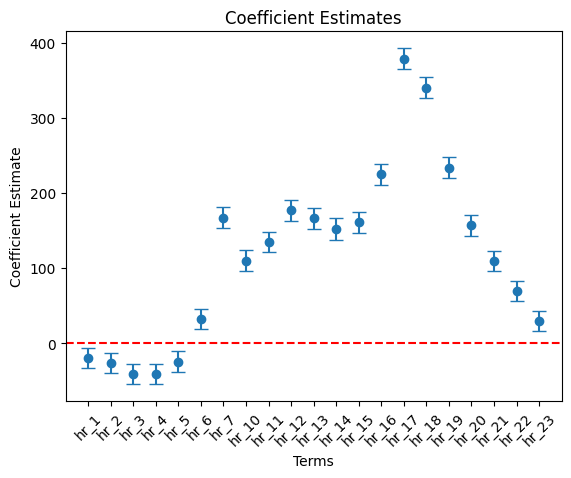

In [13]:
# Filter df_summary if needed
cond = df_summary['term'].isin(['hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_10', 'hr_11', 'hr_12',
                                'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22',
                                'hr_23', 'hr_24'])

df_summary_3 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_3["term"], df_summary_3["estimate"],
             yerr = 1.96 * df_summary_3["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

- Draw a coefficient plot for wkday variables.

In [14]:
df_summary

,term,estimate,std_error
0,temp,45.307008,2.361551
1,hum,-17.192597,1.395017
2,windspeed,-4.616665,1.094844
3,year_2012,85.360630,2.029418
4,month_2,8.508350,5.128514
5,month_3,18.322032,5.764897
6,month_4,10.783798,8.556570
7,month_5,25.990290,9.176854
8,month_6,4.946636,9.401748
9,month_7,-10.676807,10.543018


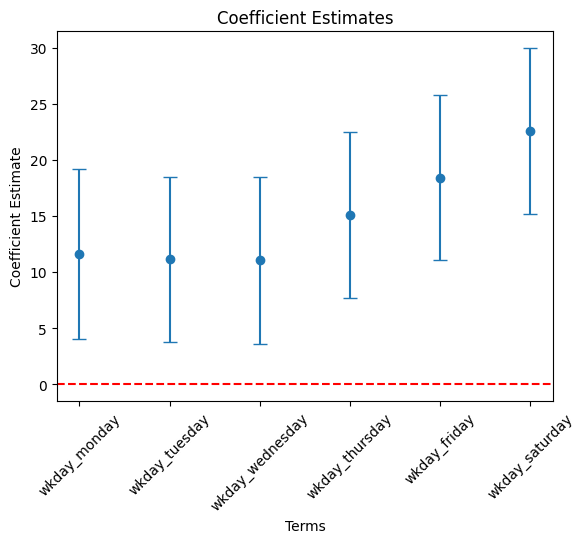

In [15]:
# Filter df_summary if needed
cond = df_summary['term'].isin(['wkday_monday', 'wkday_tuesday', 'wkday_wednesday',
                                'wkday_thursday', 'wkday_friday', 'wkday_saturday'])

df_summary_4 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_4["term"], df_summary_4["estimate"],
             yerr = 1.96 * df_summary_4["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

- Draw a coefficient plot for seasons variables.

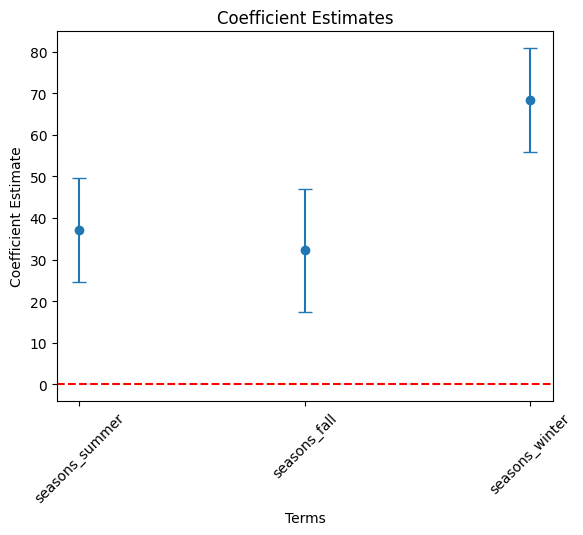

In [16]:
# Filter df_summary if needed
cond = df_summary['term'].isin(['seasons_summer', 'seasons_fall', 'seasons_winter'])

df_summary_5 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_5["term"], df_summary_5["estimate"],
             yerr = 1.96 * df_summary_5["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()


- Draw a coefficient plot for weather_cond variables.

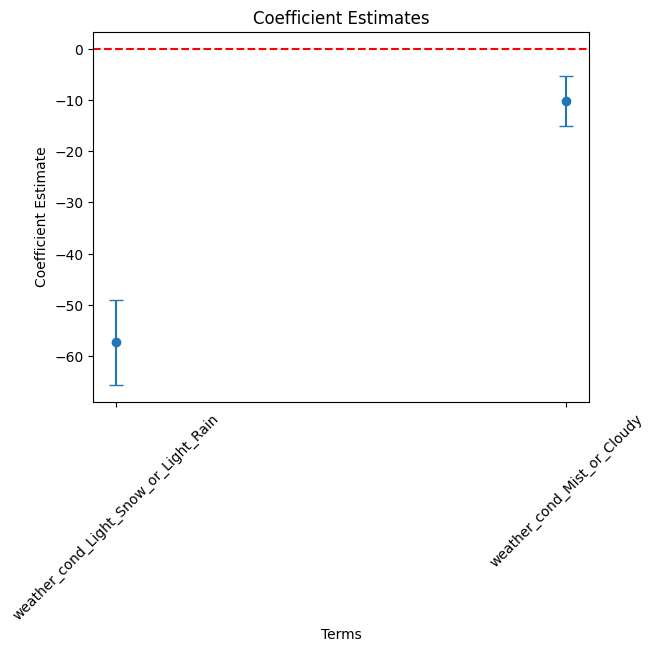

In [17]:
# Filter df_summary if needed
cond = df_summary['term'].isin(['weather_cond_Light_Snow_or_Light_Rain', 'weather_cond_Mist_or_Cloudy'])

df_summary_6 = df_summary[cond]

# Plot using the DataFrame columns
plt.errorbar(df_summary_6["term"], df_summary_6["estimate"],
             yerr = 1.96 * df_summary_6["std_error"], fmt='o', capsize=5)
plt.xlabel("Terms")
plt.ylabel("Coefficient Estimate")
plt.title("Coefficient Estimates")
plt.axhline(0, color="red", linestyle="--")  # Add horizontal line at 0
plt.xticks(rotation=45)
plt.show()

# Q8

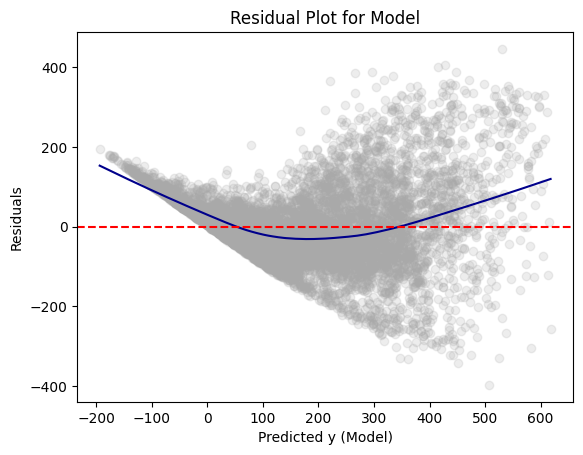

In [19]:
# Convert test predictions to Pandas
dfpd = dtest_dum.select(["prediction", "cnt"]).toPandas()
dfpd["residual"] = dfpd["cnt"] - dfpd["prediction"]
plt.scatter(dfpd["prediction"], dfpd["residual"], alpha=0.2, color="darkgray")

# Use lowess smoothing for the trend line
smoothed = sm.nonparametric.lowess(dfpd["residual"], dfpd["prediction"])
plt.plot(smoothed[:, 0], smoothed[:, 1], color="darkblue")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Predicted y (Model)")
plt.ylabel("Residuals")
plt.title("Residual Plot for Model")
plt.show()

# Q9

In [20]:
df = df.withColumn("log_cnt", log( df['cnt'] ) )
df.show()

+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+------------------+
|cnt|year|month|date| hr|   wkday|holiday|seasons|        weather_cond|              temp|              hum|         windspeed|           log_cnt|
+---+----+-----+----+---+--------+-------+-------+--------------------+------------------+-----------------+------------------+------------------+
| 16|2011|    1|   1|  0|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.947345243330896|  -1.5538438052971| 2.772588722239781|
| 40|2011|    1|   1|  1|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|3.6888794541139363|
| 32|2011|    1|   1|  2|saturday|      0| spring| Clear or Few Cloudy| -1.43847500990342|0.895512927978679|  -1.5538438052971|3.4657359027997265|
| 13|2011|    1|   1|  3|saturday|      0| spring| Clear or Few Cloudy| -1.33460918694128|0.636351351217591|  -1.55384

<Axes: xlabel='cnt', ylabel='Count'>

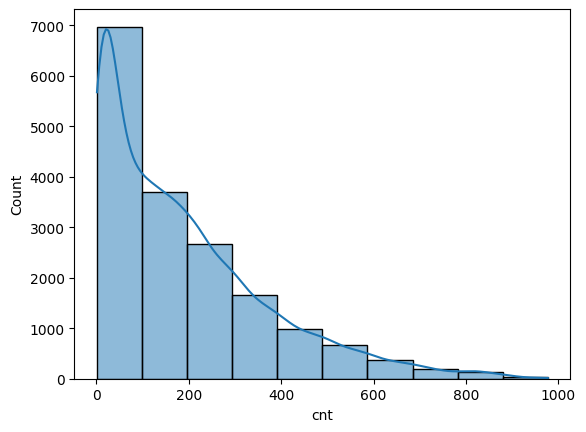

In [21]:
# Create a histogram
dfpd = df.select(["cnt"]).toPandas()
sns.histplot(dfpd["cnt"], bins=10, kde=True)

<Axes: xlabel='log_cnt', ylabel='Count'>

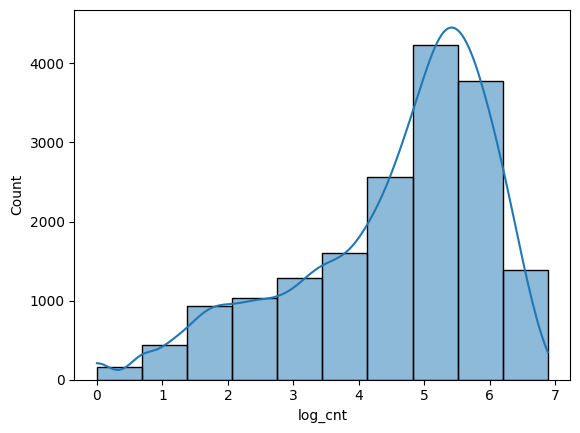

In [22]:
# Create a histogram
dfpd = df.select(["log_cnt"]).toPandas()
sns.histplot(dfpd["log_cnt"], bins=10, kde=True)

In [23]:
df.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+---------+--------------------+-------+-------------------+--------------------+--------------------+--------------------+-----------------+
|summary|              cnt|              year|             month|              date|                hr|    wkday|             holiday|seasons|       weather_cond|                temp|                 hum|           windspeed|          log_cnt|
+-------+-----------------+------------------+------------------+------------------+------------------+---------+--------------------+-------+-------------------+--------------------+--------------------+--------------------+-----------------+
|  count|            17376|             17376|             17376|             17376|             17376|    17376|               17376|  17376|              17376|               17376|               17376|               17376|            17376|
|   mean|189.48296500920

# Q10

In [24]:
dtrain, dtest = df.randomSplit([0.6, 0.4], seed = 1234)
dummy_cols_year, ref_category_year = add_dummy_variables('year', 0)
dummy_cols_month, ref_category_month = add_dummy_variables('month', 0)
dummy_cols_hr, ref_category_hr = add_dummy_variables('hr', 0)

# Example usage with category_order:
custom_order_wkday = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
dummy_cols_wkday, ref_category_wkday = add_dummy_variables('wkday', reference_level=0, category_order = custom_order_wkday)

dummy_cols_holiday, ref_category_holiday = add_dummy_variables('holiday', 0)

# Example usage with category_order:
custom_order_seasons = ['spring', 'summer', 'fall', 'winter']
dummy_cols_seasons, ref_category_seasons = add_dummy_variables('seasons', 0, custom_order_seasons)

dummy_cols_weather_cond, ref_category_weather_cond = add_dummy_variables('weather_cond', 0)

conti_cols = ["temp", "hum", "windspeed"]
assembler_predictors = (
    conti_cols +
    dummy_cols_year + dummy_cols_month +
    dummy_cols_hr + dummy_cols_wkday +
    dummy_cols_holiday + dummy_cols_seasons + dummy_cols_weather_cond
)

assembler_log = VectorAssembler(
    inputCols = assembler_predictors,
    outputCol = "predictors"
)
dtrain_log = assembler_log.transform(dtrain)
dtest_log  = assembler_log.transform(dtest)

model_log = (
    LinearRegression(featuresCol="predictors",
                     labelCol="log_cnt")
    .fit(dtrain_log)
)
dtest_log = model_log.transform(dtest_log) # Q4. adding prediction column to test data

# For model_dum and assembler:
print( regression_table(model_log, assembler_log) )


Reference category (dummy omitted): 2011
Reference category (dummy omitted): 1
Reference category (dummy omitted): 0
Reference category (dummy omitted): sunday
Reference category (dummy omitted): 0
Reference category (dummy omitted): spring
Reference category (dummy omitted): Clear or Few Cloudy
+---------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Metric                                      |  Value | Sig. | Std. Error | p-value | 95% CI Lower | 95% CI Upper |
+---------------------------------------------+--------+------+------------+---------+--------------+--------------+
| Beta: temp                                  |  0.271 | ***  |      0.008 |   0.000 |        0.254 |        0.288 |
| Beta: hum                                   | -0.056 | ***  |      0.007 |   0.000 |       -0.069 |       -0.043 |
| Beta: windspeed                             | -0.028 | ***  |      0.012 |   0.000 |       -0.053 |       -0.004 |
|

In [25]:
model_log.coefficients

DenseVector([0.2711, -0.0558, -0.0284, 0.463, 0.1457, 0.2081, 0.1774, 0.3141, 0.1884, 0.0456, 0.1228, 0.2045, 0.0846, -0.0147, -0.0222, -0.6423, -1.2472, -1.7759, -2.0569, -0.9344, 0.232, 1.2164, 1.8066, 1.5602, 1.2344, 1.3297, 1.532, 1.4938, 1.433, 1.462, 1.7276, 2.1165, 2.0256, 1.7626, 1.4612, 1.2223, 0.9516, 0.5361, -0.0235, -0.0318, -0.0275, 0.0258, 0.1339, 0.1449, -0.1455, 0.2774, 0.3416, 0.618, -0.548, -0.0423])

In [27]:
# beta estimate for windspeed
np.exp(-0.0284)

0.9719994892352246

In [28]:
1-np.exp(-0.0284)

0.028000510764775388

In [29]:
np.exp(model_log.coefficients)

array([1.31142428, 0.94568946, 0.97201379, 1.58876158, 1.15680913,
       1.23139365, 1.19410966, 1.36901519, 1.20728597, 1.04665404,
       1.13066837, 1.226877  , 1.08824095, 0.98537447, 0.97806121,
       0.52607264, 0.28729644, 0.16933921, 0.12785351, 0.39282854,
       1.26110504, 3.37494535, 6.08976616, 4.75984461, 3.43647492,
       3.77975044, 4.62762408, 4.45415496, 4.19139867, 4.31459546,
       5.62696642, 8.30169848, 7.58031849, 5.82743892, 4.31111858,
       3.39488772, 2.58975873, 1.70938738, 0.97673633, 0.96868884,
       0.97285453, 1.02609428, 1.14328126, 1.15596201, 0.86456947,
       1.31967203, 1.40724385, 1.85514444, 0.57809932, 0.9586263 ])